In [8]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
RESPONSE_VARS = df.columns[-1]

print(f'Input variables: {INPUT_VARS.values}'
      f'\nResponse variable: {RESPONSE_VARS}')
print(f'Shape of the dataframe: {df.shape}')
df.head()

Input variables: ['ERG8' 'ERG10' 'ERG12' 'ERG13' 'ERG19' 'ERG20' 'IDI1' 'tHMG1']
Response variable: prod
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,prod
0,0.862946,0.987876,0.892209,0.909210,0.848096,0.840536,0.829163,0.753874,3.739360
1,0.783979,1.001960,0.978865,0.916151,0.718987,0.827099,0.960778,0.770533,2.448719
2,0.870862,0.796111,1.096750,0.919447,0.770546,0.879257,0.956943,0.909107,2.454255
3,0.758704,0.966803,0.671244,1.044847,0.781099,1.105815,0.933287,1.084319,2.585698
4,0.941967,1.179426,0.883549,1.000001,0.941404,0.897913,0.921033,0.777849,3.298958


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]/home/costasmexis/miniconda3/envs/synthetic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/costasmexis/miniconda3/envs/synthetic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/costasmexis/miniconda3/envs/synthetic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/costasmexis/miniconda3/envs/synthetic/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iter

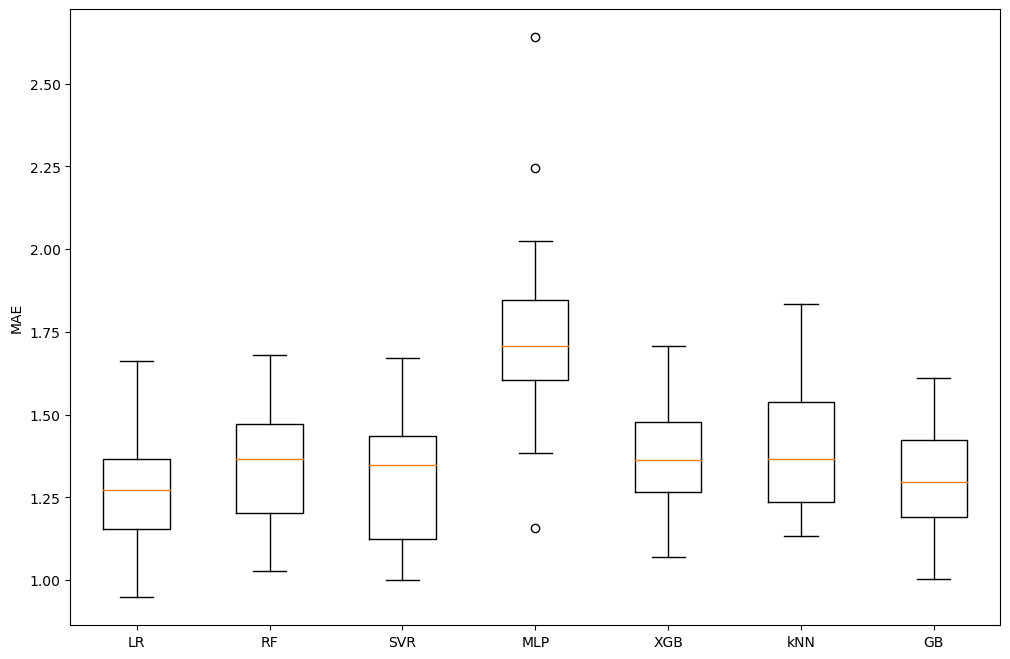

Mean MAE for LR: 1.2740392243950422
Mean MAE for RF: 1.3486891241981938
Mean MAE for SVR: 1.303432691713004
Mean MAE for MLP: 1.7593718504004145
Mean MAE for XGB: 1.3678500541985876
Mean MAE for kNN: 1.405455451546549
Mean MAE for GB: 1.2966712713288169


In [11]:
# import all above models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

regressors = {
    'LR': LinearRegression(),
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'MLP': MLPRegressor(),
    'XGB': XGBRegressor(),
    'kNN': KNeighborsRegressor(),
    'GB': GradientBoostingRegressor(),
}

# Define hyperparameter grid for each model
param_grid = {
    'LR': {'fit_intercept': [True, False]},
    'RF': {'n_estimators': [3, 5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
    'MLP': {'hidden_layer_sizes': [(25,), (10,)], 'activation': ['relu']},
    'XGB': {'n_estimators': [5, 10, 20, 50], 'max_depth': [None, 2, 3, 5, 10, 20]},
    'kNN': {'n_neighbors': [1, 2, 3, 5, 10], 'weights': ['uniform', 'distance']},
    'GB': {'n_estimators': [10, 20, 50], 'max_depth': [None, 2, 3, 5, 10]},
}

def model_selection():
    '''
        Define a function to perform the nested Cross Validation
    '''
    def nestedCV(model, p_grid, X, y):
        NUM_TRIALS = 3

        # Arrays to store scores
        nested_scores = []

        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
            outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = GridSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_grid=p_grid, 
                                    cv=inner_cv)
            
            nested_score = cross_val_score(clf, X=X, y=y, 
                                        scoring='neg_mean_absolute_error', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores

    nested_LR, nested_LR_scores = nestedCV(regressors['LR'], param_grid['LR'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_RF, nested_RF_scores = nestedCV(regressors['RF'], param_grid['RF'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_SVR, nested_SVR_scores = nestedCV(regressors['SVR'], param_grid['SVR'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_MLP, nested_MLP_scores = nestedCV(regressors['MLP'], param_grid['MLP'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_XGB, nested_XGB_scores = nestedCV(regressors['XGB'], param_grid['XGB'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_kNN, nested_kNN_scores = nestedCV(regressors['kNN'], param_grid['kNN'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())
    nested_GB, nested_GB_scores = nestedCV(regressors['GB'], param_grid['GB'], df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())

    nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
    nested_scores_RF = [-item for sublist in nested_RF_scores for item in sublist]
    nested_scores_SVR = [-item for sublist in nested_SVR_scores for item in sublist]
    nested_scores_MLP = [-item for sublist in nested_MLP_scores for item in sublist]
    nested_scores_XGB = [-item for sublist in nested_XGB_scores for item in sublist]
    nested_scores_kNN = [-item for sublist in nested_kNN_scores for item in sublist]
    nested_scores_GB = [-item for sublist in nested_GB_scores for item in sublist]
        
    # Create a box plot for the nested scores
    def boxplot(save=True):
        plt.figure(figsize=(12, 8))
        positions = [i for i in range(1, len(regressors))]
        plt.boxplot([nested_scores_LR, nested_scores_RF, nested_scores_SVR, nested_scores_MLP, nested_scores_XGB, nested_scores_kNN, nested_scores_GB], labels=['LR', 'RF', 'SVR', 'MLP', 'XGB', 'kNN', 'GB'])
        plt.ylabel('MAE')
        plt.show()

        print(f'Mean MAE for LR: {sum(nested_scores_LR)/len(nested_scores_LR)}')
        print(f'Mean MAE for RF: {sum(nested_scores_RF)/len(nested_scores_RF)}')
        print(f'Mean MAE for SVR: {sum(nested_scores_SVR)/len(nested_scores_SVR)}')
        print(f'Mean MAE for MLP: {sum(nested_scores_MLP)/len(nested_scores_MLP)}')
        print(f'Mean MAE for XGB: {sum(nested_scores_XGB)/len(nested_scores_XGB)}')
        print(f'Mean MAE for kNN: {sum(nested_scores_kNN)/len(nested_scores_kNN)}')
        print(f'Mean MAE for GB: {sum(nested_scores_GB)/len(nested_scores_GB)}')

    boxplot()
    
model_selection()

In [12]:
def train_svr(X, y):
    svr = SVR()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid['SVR'], 
                            scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X, y)
    print("Best Score:", -grid_search.best_score_)
    return grid_search

grid_search = train_svr(df[INPUT_VARS], df[RESPONSE_VARS].values.ravel())

Best Score: 1.3969950378785736


#### Explainable AI 

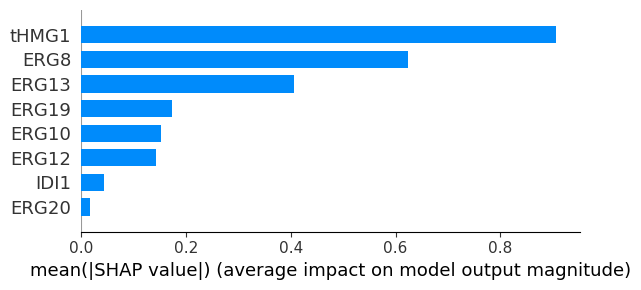

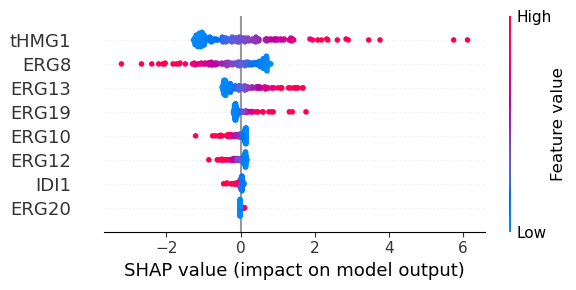

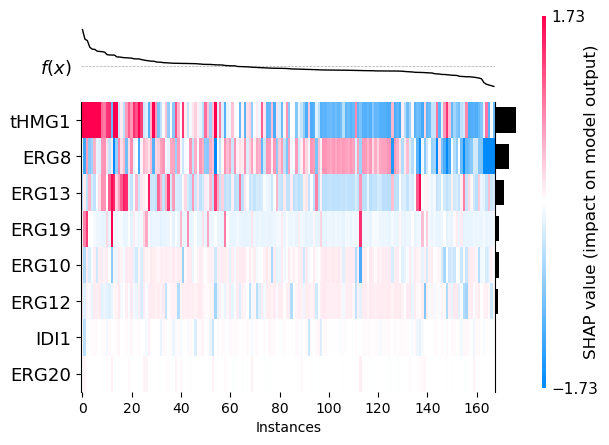

In [15]:
import shap

explainer = shap.Explainer(grid_search.best_estimator_.predict, df[INPUT_VARS])
shap_values = explainer(df[INPUT_VARS])
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

#### Sampling

In [ ]:
# import all 4 sdv models under the single table scenario
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_A.drop('Limonene', axis=1))

model_Gaussian = GaussianCopulaSynthesizer(metadata)
model_Gaussian.fit(df_A.drop('Limonene', axis=1))
synthetic_data = model_Gaussian.sample(1000)
synthetic_data['Limonene'] = grid_search.best_estimator_.predict(synthetic_data)
synthetic_data.sort_values(by='Limonene', ascending=False, inplace=True)
synthetic_data